# CLIP Embedding Verification for Refer-KITTI

This notebook verifies whether CLIP embeddings are reliable for Refer-KITTI tracking.

**Goals:**
1. Extract GT crops of referred objects from expressions
2. Compute CLIP text embeddings from natural language expressions
3. Compute CLIP image embeddings from object crops
4. Analyze text-to-image similarity distributions
5. Determine appropriate `text_sim_thresh` value
6. Visualize examples where CLIP succeeds/fails

In [1]:
import os
import json
import glob as _glob
from collections import defaultdict

import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import torch
import torch.nn.functional as F
import clip
from tqdm.auto import tqdm

%matplotlib inline
plt.rcParams['figure.figsize'] = (16, 8)

/isis/home/hasana3/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 1. Configuration

In [2]:
# === Paths ===
DATA_ROOT = "dataset/referkitti/"  # Adjust if needed
KITTI_SPLIT = "training"
IMAGES_ROOT = os.path.join(DATA_ROOT, "KITTI", KITTI_SPLIT, "image_02")
LABELS_ROOT = os.path.join(DATA_ROOT, "KITTI", KITTI_SPLIT, "labels_with_ids", "image_02")
EXPR_ROOT = os.path.join(DATA_ROOT, "expression")

# === CLIP Config ===
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
CLIP_PAD = 4  # padding around crops (same as tracker)

# === Sequences to analyze (set to None to analyze all) ===
SEQ_WHITELIST = ["0001", "0002"]  # Change to None for all sequences

print(f"Device: {DEVICE}")
print(f"Data root: {DATA_ROOT}")
print(f"Images: {IMAGES_ROOT}")
print(f"Expressions: {EXPR_ROOT}")

Device: cuda
Data root: dataset/referkitti/
Images: dataset/referkitti/KITTI/training/image_02
Expressions: dataset/referkitti/expression


## 2. Load CLIP Model

In [3]:
clip_model, clip_preprocess = clip.load("ViT-B/32", device=DEVICE)
clip_model.eval()
print(f"✓ Loaded CLIP ViT-B/32 on {DEVICE}")

✓ Loaded CLIP ViT-B/32 on cuda


## 3. Utility Functions

In [4]:
def load_expressions_for_sequence(expr_root, seq):
    """Load referring expressions for a sequence (same as eval script)."""
    seq_dir = os.path.join(expr_root, seq)
    json_paths = []
    if os.path.isdir(seq_dir):
        json_paths = sorted(_glob.glob(os.path.join(seq_dir, "*.json")))
    
    single_path = os.path.join(expr_root, f"{seq}.json")
    if os.path.isfile(single_path):
        json_paths.append(single_path)
    
    if not json_paths:
        return []
    
    result = []
    expr_counter = 0
    
    for jp in json_paths:
        with open(jp, "r") as f:
            data = json.load(f)
        
        # Refer-KITTI style
        if isinstance(data, dict) and "sentence" in data and "label" in data:
            text = data["sentence"]
            label_map = data.get("label", {})
            
            id_set = set()
            for _, ids in label_map.items():
                if isinstance(ids, (int, str)):
                    id_set.add(int(ids))
                else:
                    for tid in ids:
                        id_set.add(int(tid))
            
            if id_set:
                result.append({
                    "expr_id": expr_counter,
                    "text": text,
                    "obj_ids": sorted(id_set),
                    "json_file": os.path.basename(jp)
                })
                expr_counter += 1
    
    return result


def load_gt_for_sequence(labels_root, images_root, seq):
    """Load ground truth annotations for a sequence.
    
    Returns:
        pd.DataFrame with columns: frame_id, track_id, x_center, y_center, width, height, img_w, img_h
    """
    seq_dir = os.path.join(labels_root, seq)
    if not os.path.isdir(seq_dir):
        return pd.DataFrame()
    
    rows = []
    frame_files = sorted([f for f in os.listdir(seq_dir) if f.endswith(".txt")])
    
    for fname in frame_files:
        stem = os.path.splitext(fname)[0]
        try:
            frame_id = int(stem)
        except ValueError:
            continue
        
        # Get image size
        img_path = os.path.join(images_root, seq, f"{frame_id:06d}.png")
        if not os.path.exists(img_path):
            img_path = os.path.join(images_root, seq, f"{frame_id:06d}.jpg")
        
        img = cv2.imread(img_path)
        if img is None:
            continue
        H, W = img.shape[:2]
        
        # Parse labels (YOLO format: class_id track_id x_c y_c w h, normalized)
        label_path = os.path.join(seq_dir, fname)
        with open(label_path, "r") as f:
            for line in f:
                parts = line.strip().split()
                if len(parts) < 6:
                    continue
                try:
                    track_id = int(float(parts[1]))
                    x_c_norm = float(parts[2])
                    y_c_norm = float(parts[3])
                    w_norm = float(parts[4])
                    h_norm = float(parts[5])
                    
                    rows.append({
                        "frame_id": frame_id,
                        "track_id": track_id,
                        "x_center": x_c_norm * W,
                        "y_center": y_c_norm * H,
                        "width": w_norm * W,
                        "height": h_norm * H,
                        "img_w": W,
                        "img_h": H
                    })
                except ValueError:
                    continue
    
    return pd.DataFrame(rows)


def extract_crop(img, x_c, y_c, w, h, pad=0):
    """Extract crop from image with optional padding."""
    H, W = img.shape[:2]
    x1 = int(x_c - w / 2) - pad
    y1 = int(y_c - h / 2) - pad
    x2 = int(x_c + w / 2) + pad
    y2 = int(y_c + h / 2) + pad
    
    x1 = max(0, x1)
    y1 = max(0, y1)
    x2 = min(W, x2)
    y2 = min(H, y2)
    
    if x2 <= x1 or y2 <= y1:
        return None
    
    return img[y1:y2, x1:x2]


def compute_clip_similarity(text_embedding, image_embedding):
    """Compute cosine similarity between text and image embeddings."""
    return F.cosine_similarity(
        text_embedding.unsqueeze(0), 
        image_embedding.unsqueeze(0), 
        dim=-1
    ).item()

## 4. Collect Expression-Object Pairs

In [5]:
# Get all sequences
all_seqs = sorted([d for d in os.listdir(IMAGES_ROOT) if os.path.isdir(os.path.join(IMAGES_ROOT, d))])
if SEQ_WHITELIST:
    all_seqs = [s for s in all_seqs if s in SEQ_WHITELIST]

print(f"Analyzing {len(all_seqs)} sequences: {all_seqs}")

# Collect all expression-object pairs
expression_data = []

for seq in tqdm(all_seqs, desc="Loading sequences"):
    # Load expressions
    expressions = load_expressions_for_sequence(EXPR_ROOT, seq)
    if not expressions:
        continue
    
    # Load GT
    gt_df = load_gt_for_sequence(LABELS_ROOT, IMAGES_ROOT, seq)
    if gt_df.empty:
        continue
    
    for expr in expressions:
        text = expr["text"]
        obj_ids = expr["obj_ids"]
        
        # Find all GT boxes for these object IDs
        expr_gt = gt_df[gt_df["track_id"].isin(obj_ids)]
        
        expression_data.append({
            "seq": seq,
            "expr_id": expr["expr_id"],
            "text": text,
            "obj_ids": obj_ids,
            "num_frames": len(expr_gt["frame_id"].unique()),
            "num_instances": len(expr_gt),
            "gt_df": expr_gt
        })

print(f"\n✓ Loaded {len(expression_data)} expressions across {len(all_seqs)} sequences")
print(f"Total instances: {sum(e['num_instances'] for e in expression_data)}")

Analyzing 2 sequences: ['0001', '0002']


Loading sequences: 100%|██████████| 2/2 [00:04<00:00,  2.15s/it]


✓ Loaded 124 expressions across 2 sequences
Total instances: 63654


## 5. Compute CLIP Embeddings

In [ ]:
# Compute text embeddings for all expressions
print("Computing text embeddings...")
for expr_data in tqdm(expression_data, desc="Text embeddings"):
    text = expr_data["text"]
    with torch.no_grad():
        tokens = clip.tokenize([text]).to(DEVICE)
        text_emb = clip_model.encode_text(tokens)
        text_emb = F.normalize(text_emb, dim=-1).float().cpu()[0]
    expr_data["text_embedding"] = text_emb

print("✓ Text embeddings computed")
'''
expression_data[0]["text_embedding"].shape
'''

torch.Size([512])

In [7]:
# Compute image embeddings for crops (sample up to MAX_CROPS_PER_EXPR per expression)
MAX_CROPS_PER_EXPR = 50  # To avoid memory issues

print("Computing image embeddings...")
similarities_all = []

for expr_data in tqdm(expression_data, desc="Image embeddings"):
    seq = expr_data["seq"]
    text_emb = expr_data["text_embedding"]
    gt_df = expr_data["gt_df"]
    
    # Sample frames if too many
    if len(gt_df) > MAX_CROPS_PER_EXPR:
        gt_sample = gt_df.sample(n=MAX_CROPS_PER_EXPR, random_state=42)
    else:
        gt_sample = gt_df
    
    crops = []
    crop_metadata = []
    
    for idx, row in gt_sample.iterrows():
        frame_id = int(row["frame_id"])
        img_path = os.path.join(IMAGES_ROOT, seq, f"{frame_id:06d}.png")
        if not os.path.exists(img_path):
            img_path = os.path.join(IMAGES_ROOT, seq, f"{frame_id:06d}.jpg")
        
        img_bgr = cv2.imread(img_path)
        if img_bgr is None:
            continue
        
        crop_bgr = extract_crop(
            img_bgr,
            row["x_center"], row["y_center"],
            row["width"], row["height"],
            pad=CLIP_PAD
        )
        
        if crop_bgr is None or crop_bgr.shape[0] < 10 or crop_bgr.shape[1] < 10:
            continue
        
        crop_rgb = cv2.cvtColor(crop_bgr, cv2.COLOR_BGR2RGB)
        crop_pil = Image.fromarray(crop_rgb)
        crops.append(clip_preprocess(crop_pil).unsqueeze(0))
        crop_metadata.append({
            "frame_id": frame_id,
            "track_id": int(row["track_id"]),
            "crop_pil": crop_pil,
            "width": row["width"],
            "height": row["height"]
        })
    
    if not crops:
        continue
    
    # Batch encode
    batch = torch.cat(crops, 0).to(DEVICE)
    with torch.no_grad():
        img_embs = clip_model.encode_image(batch)
        img_embs = F.normalize(img_embs, dim=-1).float().cpu()
    
    # Compute similarities
    for i, img_emb in enumerate(img_embs):
        sim = compute_clip_similarity(text_emb, img_emb)
        similarities_all.append({
            "seq": seq,
            "expr_id": expr_data["expr_id"],
            "text": expr_data["text"],
            "frame_id": crop_metadata[i]["frame_id"],
            "track_id": crop_metadata[i]["track_id"],
            "similarity": sim,
            "crop_pil": crop_metadata[i]["crop_pil"],
            "width": crop_metadata[i]["width"],
            "height": crop_metadata[i]["height"]
        })

similarities_df = pd.DataFrame(similarities_all)
print(f"\n✓ Computed {len(similarities_df)} text-image similarity scores")

Computing image embeddings...


Image embeddings: 100%|██████████| 124/124 [00:55<00:00,  2.25it/s]


✓ Computed 6140 text-image similarity scores


## 6. Analyze Similarity Distributions

In [8]:
# Summary statistics
print("=" * 60)
print("CLIP Text-Image Similarity Statistics (GT Crops)")
print("=" * 60)
print(f"Mean:    {similarities_df['similarity'].mean():.4f}")
print(f"Median:  {similarities_df['similarity'].median():.4f}")
print(f"Std:     {similarities_df['similarity'].std():.4f}")
print(f"Min:     {similarities_df['similarity'].min():.4f}")
print(f"Max:     {similarities_df['similarity'].max():.4f}")
print(f"\nPercentiles:")
for p in [5, 10, 25, 50, 75, 90, 95]:
    val = np.percentile(similarities_df['similarity'], p)
    print(f"  {p:2d}th: {val:.4f}")

# What fraction would be dropped at different thresholds?
print(f"\n{'=' * 60}")
print("Fraction of GT crops DROPPED at different text_sim_thresh:")
print("=" * 60)
for thresh in [0.0, 0.05, 0.10, 0.15, 0.20, 0.25, 0.30]:
    dropped = (similarities_df['similarity'] < thresh).mean()
    print(f"  thresh={thresh:.2f}: {dropped*100:.1f}% dropped ({int(dropped*len(similarities_df))} / {len(similarities_df)} crops)")

CLIP Text-Image Similarity Statistics (GT Crops)
Mean:    0.2430
Median:  0.2435
Std:     0.0189
Min:     0.1764
Max:     0.3025

Percentiles:
   5th: 0.2123
  10th: 0.2182
  25th: 0.2293
  50th: 0.2435
  75th: 0.2563
  90th: 0.2677
  95th: 0.2738

Fraction of GT crops DROPPED at different text_sim_thresh:
  thresh=0.00: 0.0% dropped (0 / 6140 crops)
  thresh=0.05: 0.0% dropped (0 / 6140 crops)
  thresh=0.10: 0.0% dropped (0 / 6140 crops)
  thresh=0.15: 0.0% dropped (0 / 6140 crops)
  thresh=0.20: 1.1% dropped (65 / 6140 crops)
  thresh=0.25: 63.4% dropped (3892 / 6140 crops)
  thresh=0.30: 100.0% dropped (6138 / 6140 crops)


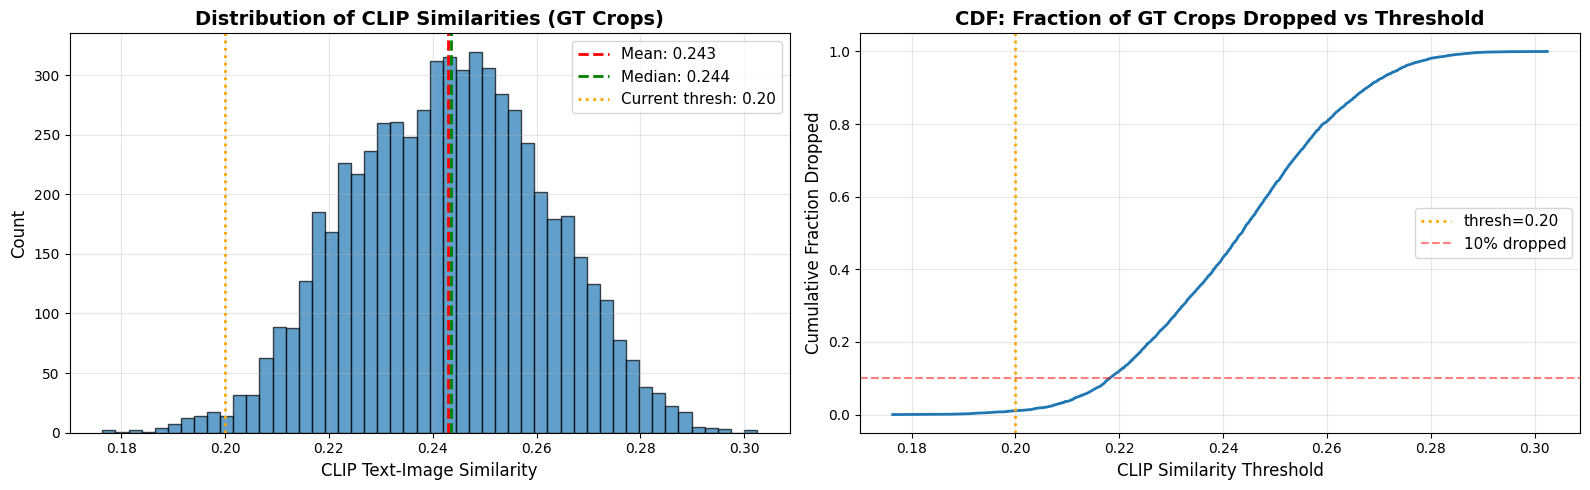


⚠️  At text_sim_thresh=0.20, you are dropping 1.1% of GT referred objects!


In [9]:
# Plot histogram
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Histogram
axes[0].hist(similarities_df['similarity'], bins=50, edgecolor='black', alpha=0.7)
axes[0].axvline(similarities_df['similarity'].mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {similarities_df["similarity"].mean():.3f}')
axes[0].axvline(similarities_df['similarity'].median(), color='green', linestyle='--', linewidth=2, label=f'Median: {similarities_df["similarity"].median():.3f}')
axes[0].axvline(0.20, color='orange', linestyle=':', linewidth=2, label='Current thresh: 0.20')
axes[0].set_xlabel('CLIP Text-Image Similarity', fontsize=12)
axes[0].set_ylabel('Count', fontsize=12)
axes[0].set_title('Distribution of CLIP Similarities (GT Crops)', fontsize=14, fontweight='bold')
axes[0].legend(fontsize=11)
axes[0].grid(alpha=0.3)

# CDF
sorted_sims = np.sort(similarities_df['similarity'])
cdf = np.arange(1, len(sorted_sims) + 1) / len(sorted_sims)
axes[1].plot(sorted_sims, cdf, linewidth=2)
axes[1].axvline(0.20, color='orange', linestyle=':', linewidth=2, label='thresh=0.20')
axes[1].axhline(0.10, color='red', linestyle='--', alpha=0.5, label='10% dropped')
axes[1].set_xlabel('CLIP Similarity Threshold', fontsize=12)
axes[1].set_ylabel('Cumulative Fraction Dropped', fontsize=12)
axes[1].set_title('CDF: Fraction of GT Crops Dropped vs Threshold', fontsize=14, fontweight='bold')
axes[1].legend(fontsize=11)
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\n⚠️  At text_sim_thresh=0.20, you are dropping {(similarities_df['similarity'] < 0.20).mean()*100:.1f}% of GT referred objects!")

## 7. Per-Expression Analysis

In [10]:
# Group by expression and compute stats
expr_stats = similarities_df.groupby(['seq', 'expr_id', 'text'])['similarity'].agg([
    ('mean', 'mean'),
    ('median', 'median'),
    ('std', 'std'),
    ('min', 'min'),
    ('max', 'max'),
    ('count', 'count')
]).reset_index()

expr_stats = expr_stats.sort_values('mean')

print("\n" + "="*80)
print("TOP 10 WORST EXPRESSIONS (lowest mean similarity)")
print("="*80)
print(expr_stats.head(10).to_string(index=False))

print("\n" + "="*80)
print("TOP 10 BEST EXPRESSIONS (highest mean similarity)")
print("="*80)
print(expr_stats.tail(10).to_string(index=False))


TOP 10 WORST EXPRESSIONS (lowest mean similarity)
 seq  expr_id                                         text     mean   median      std      min      max  count
0002       17   left cars in the counter direction of ours 0.213901 0.214830 0.014982 0.190765 0.245078     50
0001       39                    red vehicles in the right 0.221756 0.224154 0.019315 0.182142 0.268199     35
0002       35     right cars in the same direction of ours 0.222663 0.218973 0.017145 0.189431 0.250132     50
0002       52                             vehicles in left 0.222704 0.221264 0.013884 0.188267 0.249344     50
0002       48                                 turning cars 0.222784 0.219448 0.009422 0.207895 0.247752     50
0002       49                             turning vehicles 0.223081 0.222758 0.009053 0.209188 0.246824     50
0001       20      left cars in the same direction of ours 0.224342 0.227677 0.014928 0.178793 0.252471     50
0002       40 right vehicles in the same direction of ours 0.

## 8. Visualize Examples

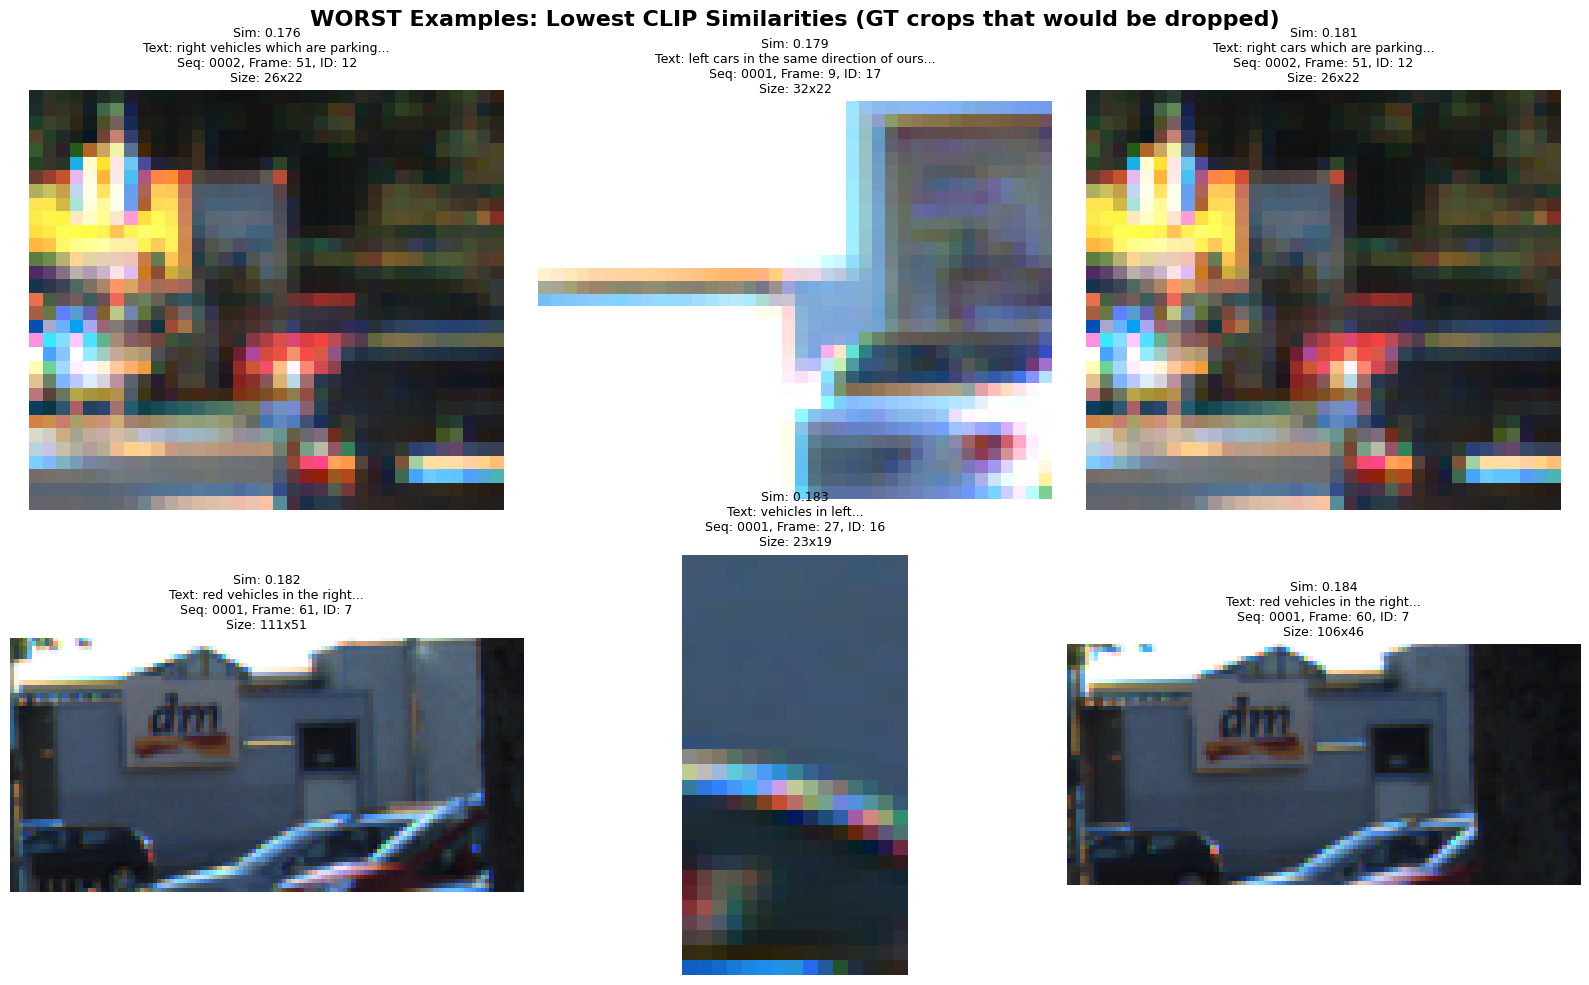

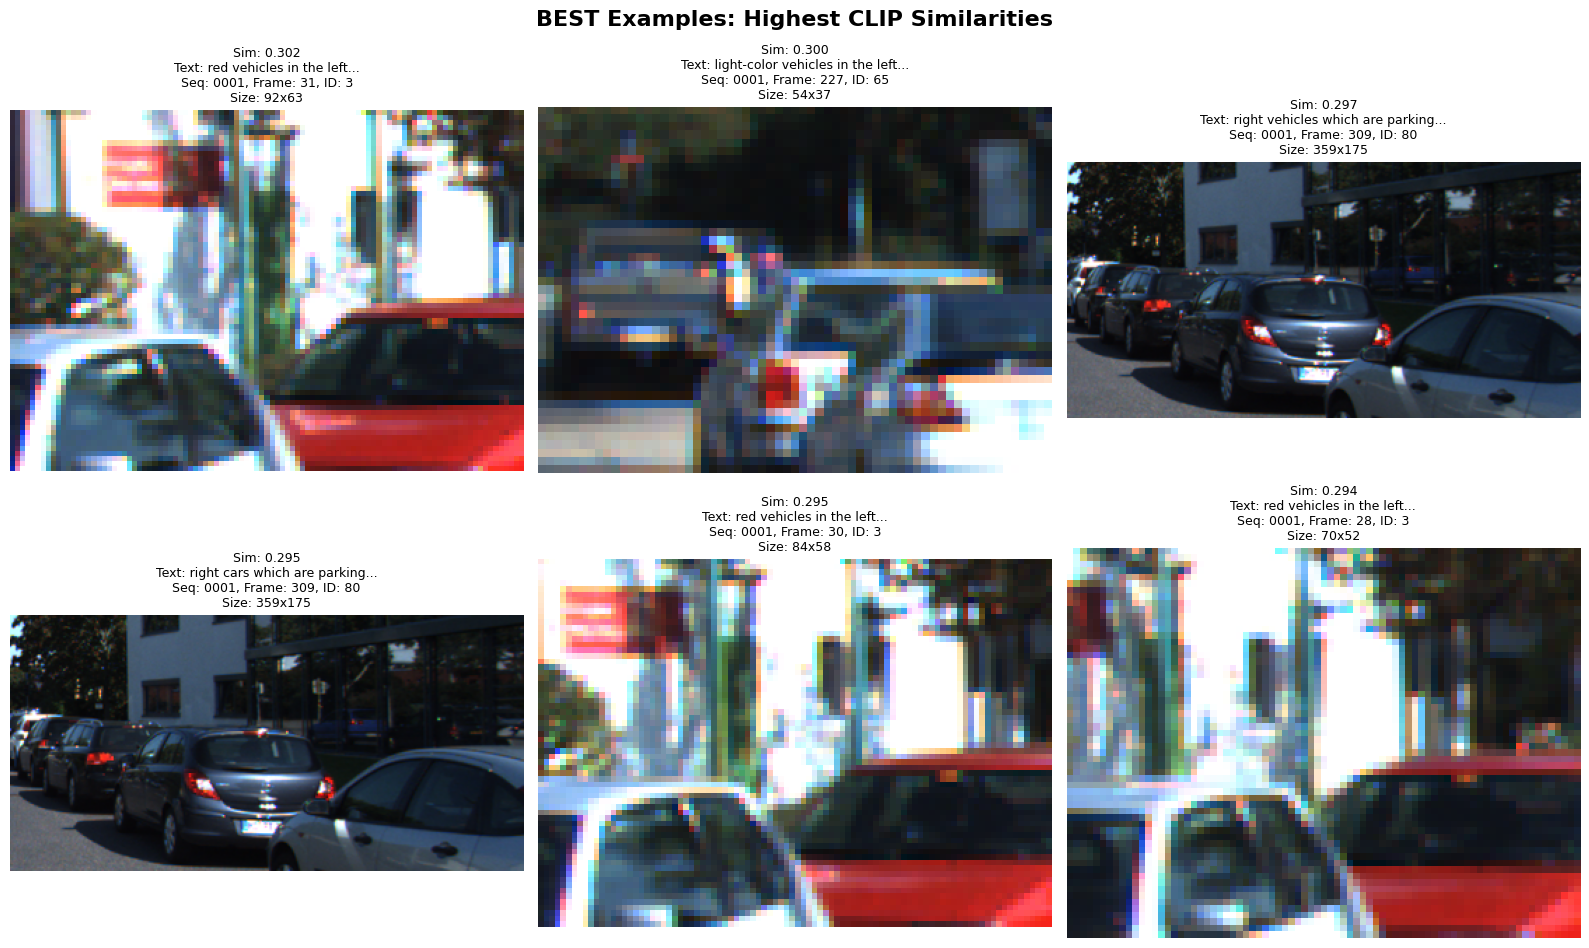

In [11]:
def visualize_examples(similarities_df, title, n=6, sort_ascending=True):
    """Visualize example crops with their similarities."""
    sorted_df = similarities_df.sort_values('similarity', ascending=sort_ascending)
    samples = sorted_df.head(n)
    
    fig, axes = plt.subplots(2, 3, figsize=(16, 10))
    axes = axes.flatten()
    
    for i, (idx, row) in enumerate(samples.iterrows()):
        if i >= len(axes):
            break
        
        axes[i].imshow(row['crop_pil'])
        axes[i].axis('off')
        axes[i].set_title(
            f"Sim: {row['similarity']:.3f}\n"
            f"Text: {row['text'][:50]}...\n"
            f"Seq: {row['seq']}, Frame: {row['frame_id']}, ID: {row['track_id']}\n"
            f"Size: {int(row['width'])}x{int(row['height'])}",
            fontsize=9
        )
    
    fig.suptitle(title, fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()

# Worst examples (lowest similarity)
visualize_examples(
    similarities_df, 
    "WORST Examples: Lowest CLIP Similarities (GT crops that would be dropped)",
    n=6, 
    sort_ascending=True
)

# Best examples (highest similarity)
visualize_examples(
    similarities_df, 
    "BEST Examples: Highest CLIP Similarities",
    n=6, 
    sort_ascending=False
)

## 9. Object Size Analysis

/tmp/ipykernel_105582/110088103.py:21: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_stats = similarities_df.groupby('area_bin')['similarity'].agg(['mean', 'std', 'count'])


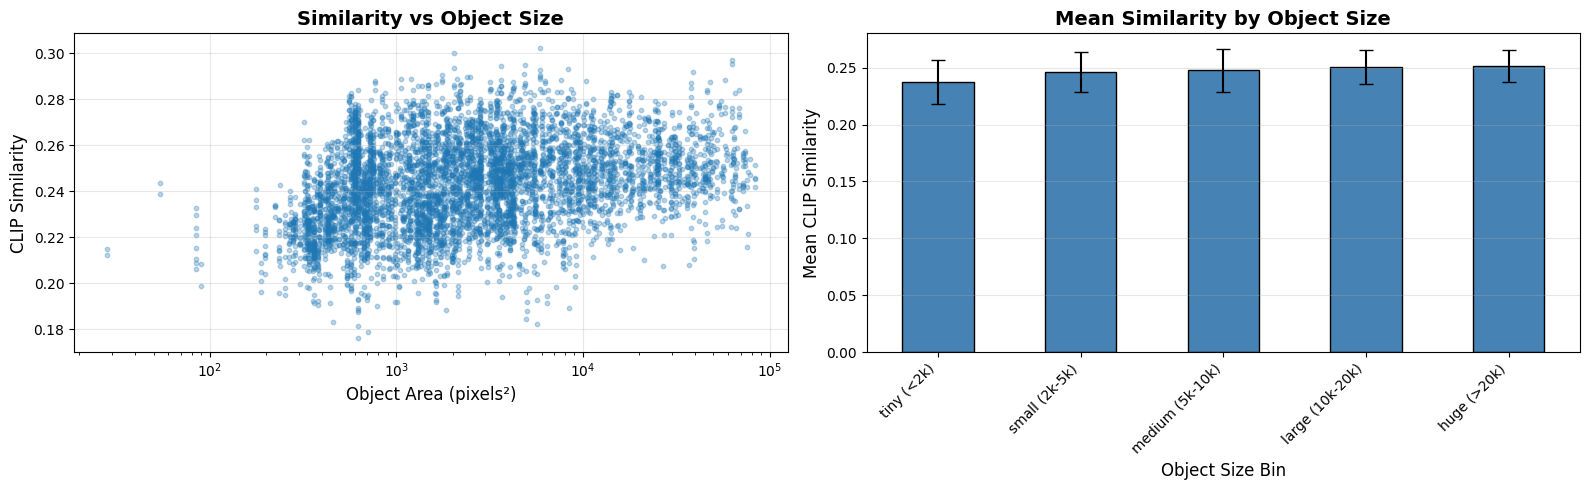


Similarity by Object Size:
                     mean       std  count
area_bin                                  
tiny (<2k)       0.237359  0.019183   2920
small (2k-5k)    0.246129  0.017816   1506
medium (5k-10k)  0.247731  0.019038    666
large (10k-20k)  0.250582  0.014702    462
huge (>20k)      0.251271  0.013785    586


In [12]:
# Analyze if similarity correlates with object size
similarities_df['area'] = similarities_df['width'] * similarities_df['height']

fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Scatter plot
axes[0].scatter(similarities_df['area'], similarities_df['similarity'], alpha=0.3, s=10)
axes[0].set_xlabel('Object Area (pixels²)', fontsize=12)
axes[0].set_ylabel('CLIP Similarity', fontsize=12)
axes[0].set_title('Similarity vs Object Size', fontsize=14, fontweight='bold')
axes[0].set_xscale('log')
axes[0].grid(alpha=0.3)

# Binned analysis
similarities_df['area_bin'] = pd.cut(
    similarities_df['area'], 
    bins=[0, 2000, 5000, 10000, 20000, 1e9],
    labels=['tiny (<2k)', 'small (2k-5k)', 'medium (5k-10k)', 'large (10k-20k)', 'huge (>20k)']
)

bin_stats = similarities_df.groupby('area_bin')['similarity'].agg(['mean', 'std', 'count'])
bin_stats['mean'].plot(kind='bar', ax=axes[1], yerr=bin_stats['std'], capsize=5, color='steelblue', edgecolor='black')
axes[1].set_xlabel('Object Size Bin', fontsize=12)
axes[1].set_ylabel('Mean CLIP Similarity', fontsize=12)
axes[1].set_title('Mean Similarity by Object Size', fontsize=14, fontweight='bold')
axes[1].grid(alpha=0.3, axis='y')
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45, ha='right')

plt.tight_layout()
plt.show()

print("\nSimilarity by Object Size:")
print(bin_stats)

## 10. Recommendations

In [13]:
# Compute recommended threshold (keep 95% of GT crops)
thresh_95 = np.percentile(similarities_df['similarity'], 5)
thresh_90 = np.percentile(similarities_df['similarity'], 10)

print("\n" + "="*80)
print("RECOMMENDATIONS")
print("="*80)

current_drop_rate = (similarities_df['similarity'] < 0.20).mean()
print(f"\n1. Current Setting (text_sim_thresh=0.20):")
print(f"   - Drops {current_drop_rate*100:.1f}% of GT referred objects")
if current_drop_rate > 0.10:
    print(f"   ⚠️  WARNING: This is TOO AGGRESSIVE! You're losing valuable GT objects.")
else:
    print(f"   ✓ Acceptable drop rate.")

print(f"\n2. Recommended Thresholds:")
print(f"   - To keep 95% of GT crops: text_sim_thresh={thresh_95:.3f}")
print(f"   - To keep 90% of GT crops: text_sim_thresh={thresh_90:.3f}")
print(f"   - Conservative (disable gating): text_sim_thresh=0.0")

print(f"\n3. Observations:")
if similarities_df['similarity'].std() > 0.15:
    print(f"   - High variance in similarities (std={similarities_df['similarity'].std():.3f})")
    print(f"   - Some expressions match well, others poorly")
    print(f"   - Consider expression-adaptive thresholding or disable gating")

correlation = np.corrcoef(similarities_df['area'], similarities_df['similarity'])[0, 1]
print(f"   - Correlation(area, similarity) = {correlation:.3f}")
if correlation > 0.3:
    print(f"   - Larger objects have higher similarity → small objects get dropped more")

print(f"\n4. Action Items:")
print(f"   [ ] Run Experiment 1: Set text_sim_thresh=0.0 (disable gating)")
print(f"   [ ] Compare MOTA with/without text gating")
print(f"   [ ] If gating helps, use thresh={thresh_95:.3f} instead of 0.20")
print(f"   [ ] Consider using CLIP only in unconfirmed stage (--use_clip_in_unconf)")
print("\n" + "="*80)


RECOMMENDATIONS

1. Current Setting (text_sim_thresh=0.20):
   - Drops 1.1% of GT referred objects
   ✓ Acceptable drop rate.

2. Recommended Thresholds:
   - To keep 95% of GT crops: text_sim_thresh=0.212
   - To keep 90% of GT crops: text_sim_thresh=0.218
   - Conservative (disable gating): text_sim_thresh=0.0

3. Observations:
   - Correlation(area, similarity) = 0.194

4. Action Items:
   [ ] Run Experiment 1: Set text_sim_thresh=0.0 (disable gating)
   [ ] Compare MOTA with/without text gating
   [ ] If gating helps, use thresh=0.212 instead of 0.20
   [ ] Consider using CLIP only in unconfirmed stage (--use_clip_in_unconf)



## 11. Export Results

In [14]:
# Save summary CSV
output_csv = "clip_embedding_analysis_referkitti.csv"
similarities_df[['seq', 'expr_id', 'text', 'frame_id', 'track_id', 'similarity', 'width', 'height', 'area']].to_csv(
    output_csv, index=False
)
print(f"✓ Saved detailed results to: {output_csv}")

# Save expression-level summary
expr_summary_csv = "clip_embedding_analysis_per_expression.csv"
expr_stats.to_csv(expr_summary_csv, index=False)
print(f"✓ Saved per-expression summary to: {expr_summary_csv}")

✓ Saved detailed results to: clip_embedding_analysis_referkitti.csv
✓ Saved per-expression summary to: clip_embedding_analysis_per_expression.csv
